# 公司生命周期

## 加载模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## 读入文件

_Warning: `df_stock['SICCD'] == 'Z'` 的情况将值转换为 -1_

_Warning: `df_stock['DLRET'].isin(['S', 'P', 'T'])` 的情况将值转换为 nan_

_Warning: `df_stock['RET'] == 'C'` 的情况将值转换为 0_

In [2]:
df_stock = pd.read_csv('../data/stock-monthly.csv', dtype={'SICCD': object, 'DLRET': object, 'RET': object})
df_stock['SICCD'] = df_stock['SICCD'].replace('Z', -1).astype(int)
df_stock['DLRET'] = df_stock['DLRET'].replace(['S', 'P', 'T'], np.nan).astype(float)
df_stock['RET'] = df_stock['RET'].replace('C', 0.).astype(float)
df_accounting = pd.read_csv('../data/accounting-annual.csv')

初步处理

In [3]:
coms = df_stock['PERMNO'].unique()
print(f'公司样本数: {coms.size}')
df_accounting = df_accounting[df_accounting['LPERMNO'].isin(coms)]
df_accounting = df_accounting.sort_values(by=['LPERMNO', 'fyear'])

df_stock['date'] = pd.to_datetime(df_stock['date'])
df_accounting['datadate'] = pd.to_datetime(df_accounting['datadate'])

公司样本数: 15320


## 定义公司周期

_Warning: 等于 0 的现金流按照大于 0 处理_

In [4]:
def life_cycle_stage(acc):
    '''
    根据现金流符号定义公司周期阶段
    acc: accounting information
    oancf: 经营活动现金流
    ivncf: 投资活动现金流
    fincf: 筹资活动现金流
    等于 0 的现金流按照大于 0 处理
    '''
    map_oif_2_stg = {(-1, -1, 1): 'Intro', (1, -1, 1): 'Growth', (1, -1, -1): 'Mature',
                     (-1, -1, -1): 'Shakeout', (1, 1, 1): 'Shakeout', (1, 1, -1): 'Shakeout',
                     (-1, 1, 1): 'Decline', (-1, 1, -1): 'Decline'}
    oif = np.sign([acc['oancf'], acc['ivncf'], acc['fincf']])
    if (np.any(np.isnan(oif))):
        return 'Unknown'
    oif[np.where(oif == 0.)] = 1.
    return map_oif_2_stg[tuple(oif)]

In [5]:
accounting_year = np.arange(1988, 2023)
stg = df_accounting.apply(life_cycle_stage, axis=1)
df_accounting['stg'] = stg

### EXHIBIT2

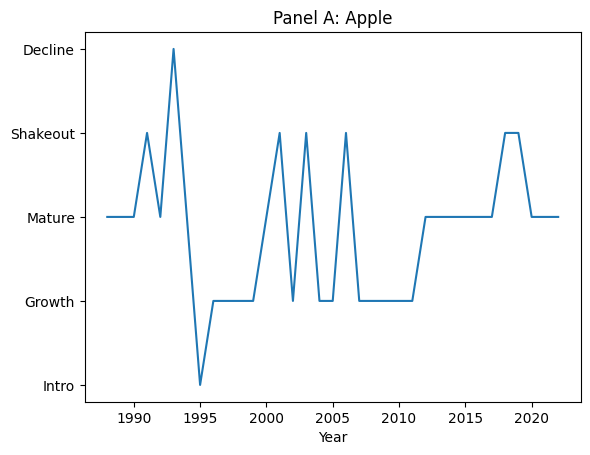

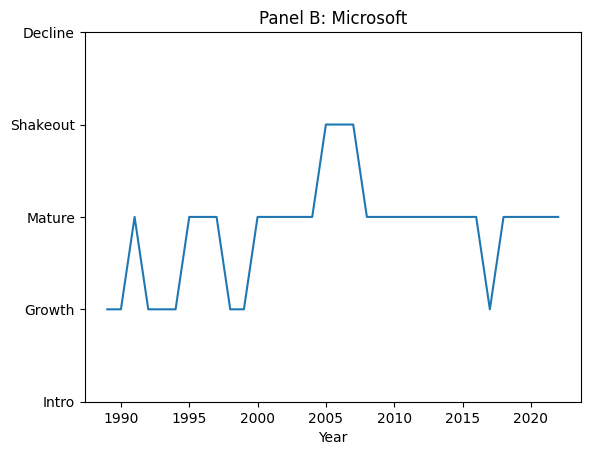

In [6]:
index_stg = ['Intro', 'Growth', 'Mature', 'Shakeout', 'Decline']
map_stg_2_num = {stg: num for stg, num in zip(index_stg, range(5))}

stg_apple = df_accounting[df_accounting['conm'] == 'APPLE INC']['stg']
stg_microsoft = df_accounting[df_accounting['conm'] == 'MICROSOFT CORP']['stg']
stg_num_apple = stg_apple.apply(map_stg_2_num.get)
stg_num_microsoft = stg_microsoft.apply(map_stg_2_num.get)

plt.plot(accounting_year, stg_num_apple)
plt.gca().set_yticks(range(5))
plt.gca().set_yticklabels(index_stg)
plt.xlabel('Year')
plt.title('Panel A: Apple')
plt.savefig('../figures/Exhibit2-PanelA.png')
plt.show()

plt.plot(accounting_year, stg_num_microsoft)
plt.gca().set_yticks(range(5))
plt.gca().set_yticklabels(index_stg)
plt.xlabel('Year')
plt.title('Panel B: Microsoft')
plt.savefig('../figures/Exhibit2-PanelB.png')
plt.show()

### 融合 `df_stock` 与 `df_accounting`

使用 6 个月以前的最新的财报数据

_Warning: 公司在 1989 年的前几个月，可能没有 6 个月前的财报数据，通过采用表格中最老的数据 (1988 年) 来解决。比较好的解决方法可能是下载从 1987 开始的数据_

In [24]:
df_stock['date_6_month'] = df_stock['date'] - pd.DateOffset(months=6)
first_records = df_accounting.groupby('LPERMNO').first()[['fyear', 'stg']]

df_merge = pd.merge_asof(
    df_stock.sort_values(['date_6_month']),
    df_accounting.sort_values(['datadate']),
    left_on='date_6_month',
    right_on='datadate',
    left_by='PERMNO',
    right_by='LPERMNO',
    direction='backward'
)
mask = df_merge['fyear'].isna()
df_merge.loc[mask, 'fyear'] = df_merge.loc[mask, 'PERMNO'].map(first_records['fyear'])
df_merge.loc[mask, 'stg'] = df_merge.loc[mask, 'PERMNO'].map(first_records['stg'])

df_merge = df_merge.sort_values(['PERMNO', 'date'])
df_merge.loc[df_merge['PERMNO'] <= 10007, ['PERMNO', 'date', 'datadate', 'fyear', 'stg']]

,PERMNO,date,datadate,fyear,stg
0,10005,1989-01-31,NaT,1988.0,Intro
7940,10005,1989-02-28,NaT,1988.0,Intro
11849,10005,1989-03-31,NaT,1988.0,Intro
17590,10005,1989-04-28,NaT,1988.0,Intro
22290,10005,1989-05-31,NaT,1988.0,Intro
26317,10005,1989-06-30,NaT,1988.0,Intro
27233,10005,1989-07-31,1988-12-31,1988.0,Intro
31863,10005,1989-08-31,1988-12-31,1988.0,Intro
38650,10005,1989-09-29,1988-12-31,1988.0,Intro
40565,10005,1989-10-31,1988-12-31,1988.0,Intro


### EXHIBIT 3

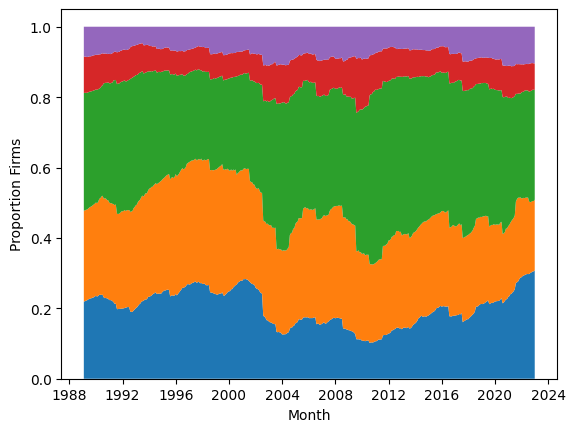

In [37]:
time_series = df_merge['date'].sort_values().unique()
df_frac = pd.DataFrame(time_series, columns=['date'])
count = df_merge[df_merge['stg'] != 'Unknown'].groupby('date').count()
df_frac['Total'] = df_frac['date'].map(count['stg'])
for stage in index_stg:
    stg_count = df_merge[df_merge['stg'] == stage].groupby('date').count()
    df_frac[stage] = df_frac['date'].map(stg_count['stg'])
    df_frac[stage] = df_frac[stage] / df_frac['Total']
frac_values = [df_frac[stage] for stage in index_stg]
plt.stackplot(time_series, frac_values, labels=index_stg)
plt.xlabel('Month')
plt.ylabel('Proportion Firms')
# plt.legend()
plt.savefig('../figures/Exhibit3.png')
plt.show()